In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.sr_dataset import DatasetSR
from PIL import Image as im

from models.EDSR import EDSR
import torch
import torch.nn as nn
from utils.utils import calculate_psnr,calculate_ssim
from tqdm import tqdm
from dataset.sr_dataset import DatasetSR
from einops import rearrange
from torch.utils.data import DataLoader
import cv2
import glob

573
36.188495379690735


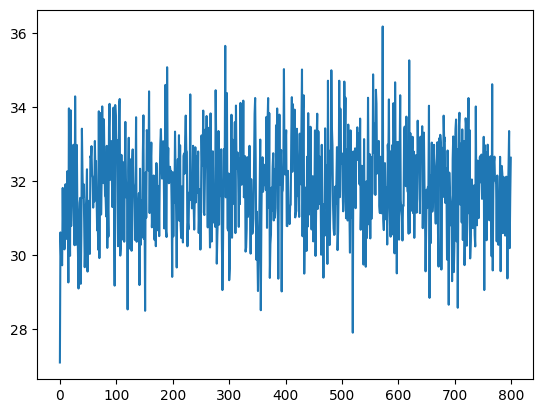

In [3]:
psnr=np.load('psnr.npy')
idx=np.argmax(psnr)
print(idx+1)
print(psnr[idx])
plt.plot(psnr)

In [6]:
device='cuda:0' if torch.cuda.is_available() else 'cpu'
model=EDSR(scale=2)
weight=torch.load('/home/joowan/Desktop/Transformer/experiment/EDSR/640000_326.4022145691319_3.398732900619507_.pt')
model.load_state_dict(weight)
model.to(device)

val_dataset=DatasetSR(phase='val')
val_dataloader=DataLoader(val_dataset,batch_size=1,num_workers=1,shuffle=True)

val_tq=tqdm(val_dataloader, ncols=80, smoothing=0, bar_format='val: {desc}|{bar}{r_bar}')

current_loss=0
psnr=0
ssim=0
criterion=nn.L1Loss()
with torch.no_grad():
    for idx,imgs in enumerate(val_tq):
        HR_img=imgs['H'].to(device)
        LR_img=imgs['L'].to(device)
        
        output_img=model(LR_img)
        current_loss+=criterion(output_img,HR_img)
        
        output_img=output_img[0].cpu().numpy()
        HR_img=HR_img[0].cpu().numpy()
        output_img=(rearrange(output_img,'c h w -> h w c'))
        HR_img=(rearrange(HR_img,'c h w -> h w c'))

        psnr+=calculate_psnr(output_img,HR_img,crop_border=8)
        ssim+=calculate_ssim(output_img,HR_img,crop_border=8)
        
        
        #####################
        # save result image #
        #####################
        
        # output_img=cv2.cvtColor(output_img,cv2.COLOR_BGR2RGB)
        # HR_img=cv2.cvtColor(HR_img,cv2.COLOR_BGR2RGB)
        # LR_img=LR_img[0].cpu().numpy()
        # LR_img=(rearrange(LR_img,'c h w -> h w c'))
        # LR_img=cv2.cvtColor(LR_img,cv2.COLOR_BGR2RGB)
        # LR_img=cv2.resize(LR_img,(output_img.shape[1],output_img.shape[0]),)
        
        # cv2.imwrite(f'SR_{idx}.png',output_img)
        # cv2.imwrite(f'HR_{idx}.png',HR_img)
        # cv2.imwrite(f'LR_{idx}.png',LR_img)
        
        
    epoch_loss=current_loss / 100
    avg_psnr=psnr / 100
    avg_ssim=ssim / 100
    
    print(avg_psnr)
    print(avg_ssim)
    
    

val: |████████████████████████████████████████| 100/100 [01:17<00:00,  1.28it/s]

32.01820390434639
0.9132532086911965


In [11]:
di={}

In [12]:
weights=glob.glob('experiment/EDSR/*.pt')
print(weights)

['experiment/EDSR/160000_294.1781934428423_3.4552531242370605_.pt', 'experiment/EDSR/464000_318.473279013522_3.6634840965270996_.pt', 'experiment/EDSR/96000_318.41367927506275_5.6843037605285645_.pt', 'experiment/EDSR/psnr_best.pt', 'experiment/EDSR/544000_315.78516350749584_4.053805828094482_.pt', 'experiment/EDSR/32000_334.2536207270762_5.125857830047607_.pt', 'experiment/EDSR/352000_307.7662325814708_4.145846843719482_.pt', 'experiment/EDSR/528000_330.4978839355192_4.7606401443481445_.pt', 'experiment/EDSR/336000_312.03507432285954_4.522307872772217_.pt', 'experiment/EDSR/272000_320.61738657583555_4.118651866912842_.pt', 'experiment/EDSR/144000_334.14750122141055_3.2512011528015137_.pt', 'experiment/EDSR/240000_322.125120493021_3.969233751296997_.pt', 'experiment/EDSR/496000_352.73295003551186_4.355182647705078_.pt', 'experiment/EDSR/208000_328.18203060247504_3.9072718620300293_.pt', 'experiment/EDSR/608000_320.63637232810146_3.680809259414673_.pt', 'experiment/EDSR/128000_311.44047

In [5]:
import json
with open('dict.json','r') as f:
    data=json.load(f)
    
print(data)

{'experiment/EDSR/160000_294.1781934428423_3.4552531242370605_.pt': [31.867836427475982, 0.9099560228149995, 4.378818035125732], 'experiment/EDSR/464000_318.473279013522_3.6634840965270996_.pt': [31.987191051864393, 0.9127008819633023, 4.243149757385254], 'experiment/EDSR/96000_318.41367927506275_5.6843037605285645_.pt': [31.71711115674538, 0.9084477273474252, 4.52945613861084], 'experiment/EDSR/psnr_best.pt': [32.01415501938378, 0.9130680075954719, 4.2107744216918945], 'experiment/EDSR/544000_315.78516350749584_4.053805828094482_.pt': [32.01640656747869, 0.913125585369772, 4.222419261932373], 'experiment/EDSR/32000_334.2536207270762_5.125857830047607_.pt': [31.488531850018163, 0.9022898689499289, 4.7412519454956055], 'experiment/EDSR/352000_307.7662325814708_4.145846843719482_.pt': [32.01217465727243, 0.9127452508762565, 4.23046350479126], 'experiment/EDSR/528000_330.4978839355192_4.7606401443481445_.pt': [32.01258525119551, 0.9130789804563662, 4.222518444061279], 'experiment/EDSR/336

In [14]:
sorted_dict = dict(sorted(data.items(), key=lambda x: x[1][0]))

AttributeError: 'list' object has no attribute 'values'

In [11]:
data

[('experiment/EDSR/112000_313.79666711700577_3.0346450805664062_.pt',
  [31.495088161432093, 0.9051539954101555, 4.719272136688232]),
 ('experiment/EDSR/128000_311.44047374071147_4.096179008483887_.pt',
  [31.916860267775533, 0.9109866834547786, 4.346804618835449]),
 ('experiment/EDSR/144000_334.14750122141055_3.2512011528015137_.pt',
  [31.678322480131772, 0.902587651467564, 4.587840557098389]),
 ('experiment/EDSR/160000_294.1781934428423_3.4552531242370605_.pt',
  [31.867836427475982, 0.9099560228149995, 4.378818035125732]),
 ('experiment/EDSR/16000_339.24242554089915_3.9408199787139893_.pt',
  [31.632428694473134, 0.9051225684036761, 4.607484817504883]),
 ('experiment/EDSR/176000_326.8618776717769_4.500341415405273_.pt',
  [31.95365476697988, 0.9120786893593903, 4.271016597747803]),
 ('experiment/EDSR/192000_315.6887242896363_3.8416764736175537_.pt',
  [31.929104887138884, 0.9106747597417294, 4.3136210441589355]),
 ('experiment/EDSR/1_best.pt',
  [32.01996160422072, 0.91323336906842